## PyTorch 
### Build Model 
#### Build the Neural Network

In [3]:
import os
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
# Get Device for Training
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")  

Using mps device


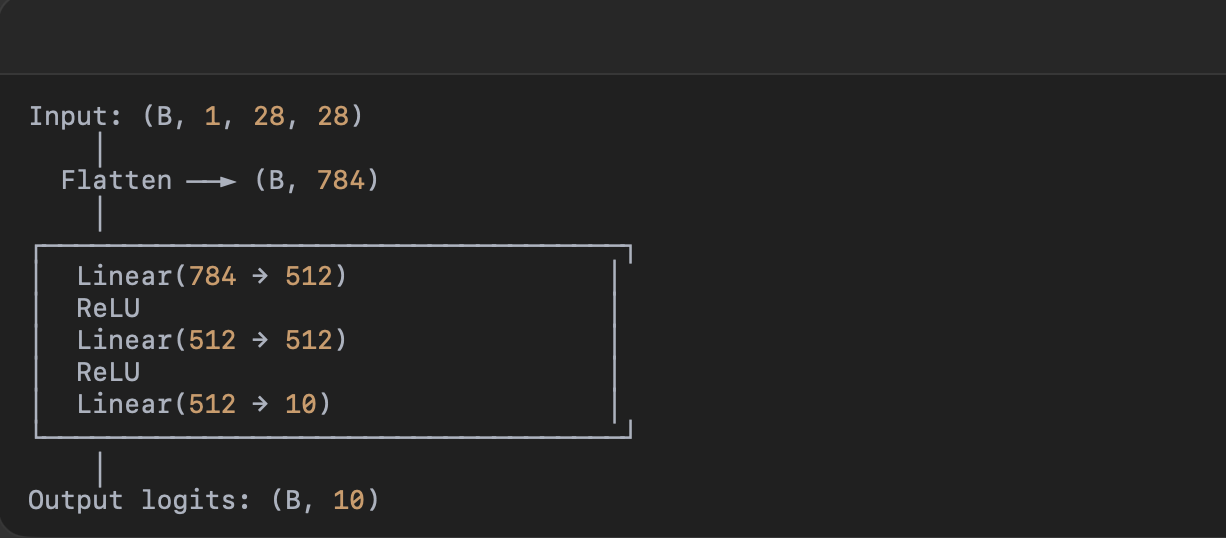

In [5]:
# Define the Class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 1) Flatten 4D image (batch, channel, height, width) --> 2D Tensor (batch, c*h*w)
        self.flatten = nn.Flatten()
        
        # 2) Linter + ReLU --> Stack 
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # input 784 --> output 512
            nn.ReLU(),   # nonlinear 
            nn.Linear(512, 512),   # 512->512
            nn.ReLU(),   
            nn.Linear(512,10)   # 512 --> 10 (# of class)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

1. **Inheriting from `nn.Module`**  
   - Every PyTorch layer/module subclasses `nn.Module`.  
   - In `__init__`, define **sub-modules** (layers).  
   - In `forward(self, x)`, implement the **forward pass** logic.

2. **Flatten layer**  
   - Converts a 4D image tensor `(batch, channel, height, width)`  
     into a 2D tensor `(batch, channel*height*width)`.  
   - Here: `(B, 1, 28, 28)` → `(B, 784)`.

3. **Sequential stack**  
   - `nn.Sequential(...)` calls its internal layers **in order**.  
   - By placing `ReLU` between `Linear` layers, you build a simple **MLP**.

4. **`forward` method**  
   - Automatically invoked by PyTorch when the model receives input.  
   - Processes input `x` through your defined layers.  
   - Returns the **raw logits** (to be consumed by a softmax + loss function).



In [6]:
model = NeuralNetwork().to(device) 
## NeuralNetwork class의 새 객체 만들고 --> .to(device)로 GPU/CPU로 옮김 --> 결과를 model에 저장 
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


4. **Model instantiation & device transfer**  
```python
model = NeuralNetwork().to(device)
```

- .to(device) moves all model parameters (weights & biases) onto the specified device (GPU or CPU).

In [7]:
# 1) Create a random “image” on the chosen device:
X = torch.rand(1, 28, 28, device=device)
#    shape (1, 28, 28) because batch=1, grayscale 28×28

# 2) Call the model:
logits = model(X)
#  → actually does: model.__call__(X)
#      • runs any registered hooks (Dropout, BatchNorm modes, etc.)
#      • calls model.forward(X)
#      • returns the raw scores (“logits”), shape (1, 10)

# 3) Convert logits to probabilities:
pred_probab = nn.Softmax(dim=1)(logits)
#  → shape still (1, 10), each row sums to 1

# 4) Pick the most likely class:
y_pred = pred_probab.argmax(1)
#  → looks across dim=1 (the 10 classes)
#  → returns tensor([class_index]), e.g. tensor([2])

print(f"Predicted class: {y_pred}")
#  Predicted class: tensor([2], device='cuda:0')

Predicted class: tensor([7], device='mps:0')


## Model Layers
### Breaking down the layers in the FashionMNIST model
#### a sample minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network

In [8]:
input_image = torch.rand(3, 28, 28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn. Flatten
#### we initialize the nn.Flatten layer to convert each 2D 28x28 image --> array of 784 pixel vals 

In [9]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size()) # 28,28 --> 784 (2D->1D)

torch.Size([3, 784])


### nn.Linear
#### A module that applies a linear transformation on the input using its stored weights and biases 

In [10]:
layer1 = nn.Linear(in_features=28*28, out_features=20) # y = xW^T + b
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU
#### Non-linear activations (negative values --> 0, keep positive values unchanged)

In [11]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1=nn.ReLU()(hidden1) # nn.ReLU(hidden1) (X), nn.ReLU()로 instance 생성 --> hidden1입력
print(f"After ReLU: {hidden1}") # all the negative values converted to 0

Before ReLU: tensor([[ 0.0801,  0.1777,  0.3866, -0.2203, -0.0412, -0.3272,  0.2991,  0.5175,
         -0.2646, -0.1619,  0.5184, -0.5931, -0.2042, -0.5550, -0.3975, -0.1243,
          0.1400,  0.2034, -0.3721,  0.3676],
        [-0.2015,  0.1739,  0.4523,  0.1003,  0.1155, -0.2869, -0.1291,  0.7946,
         -0.2222, -0.1245,  0.2289, -0.1916,  0.0278, -0.4957, -0.5816,  0.1714,
         -0.0995,  0.3544, -0.3498,  0.4083],
        [-0.1000, -0.0252,  0.2981, -0.1805,  0.2773, -0.4396,  0.0346,  0.6720,
         -0.1709,  0.0480,  0.5973, -0.3165, -0.1541, -0.5171, -0.6266, -0.1311,
         -0.0946,  0.2301, -0.3689,  0.4668]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0801, 0.1777, 0.3866, 0.0000, 0.0000, 0.0000, 0.2991, 0.5175, 0.0000,
         0.0000, 0.5184, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1400, 0.2034,
         0.0000, 0.3676],
        [0.0000, 0.1739, 0.4523, 0.1003, 0.1155, 0.0000, 0.0000, 0.7946, 0.0000,
         0.0000, 0.2289, 0.0000, 0.0278, 0.0000, 0.00

hidden1=nn.ReLU()(hidden1) 은 아래 두 줄을 하나로 합친 것과 동일 
```
activation = nn.ReLU()    # 1) 모듈 생성
output     = activation(hidden1)  # 2) forward(hidden1) 호출
```

### nn.Sequential
#### Ordered container: the data is passed through all the modules in the same order as defined

In [12]:

seq_modules = nn.Sequential(
    flatten, #(3,28,28) ->(3, 784)
    layer1, # nn.Linear(28*28, 20) (784 --> 20)
    nn.ReLU(), # (20 --> 20)
    nn.Linear(20,10) # hidden layer (20) --> number of class (10) that can be used for softmax, CE, etc.
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

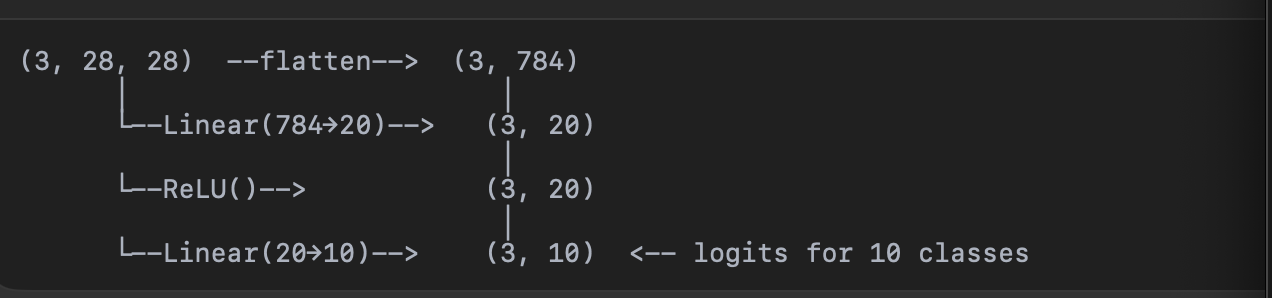

### nn.Softmax
#### logits --> prob (0,1)

In [14]:
softmax = nn.Softmax(dim=1) # score --> prob.
pred_probab = softmax(logits)


### Model Parameters
#### To see how the weights and biases are optimized during training


In [15]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values tensor([[-0.0286,  0.0071,  0.0019,  ..., -0.0011,  0.0095,  0.0020],
        [ 0.0215,  0.0148, -0.0205,  ...,  0.0320,  0.0198, -0.0035]],
       device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values tensor([0.0286, 0.0120], device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values tensor([[-0.0096, -0.0397, -0.0151,  ...,  0.0156, -0.0099,  0.0172],
        [ 0.0323,  0.0248, -0.0248,  ..., -0.0368,  0.0360, -0.0209]],
       device='mps:0', grad_fn=<SliceBackward

## Inspecting Model Parameters

- **`.named_parameters()`**  
  - Iterates over **all learnable parameters** in the model as `(name, tensor)` pairs.  
  - **Why it matters**: Quickly see every weight and bias your network will optimize.

- **Parameter names**  
  - Automatically generated in the form  
    ```
    <module_name>.<layer_index>.<weight or bias>
    ```  
  - **Why it matters**: Helps you pinpoint exactly which layer a parameter belongs to.

- **`param.size()`**  
  - Returns the **shape** of the parameter tensor.  
  - **Why it matters**: Verifies that your layers have the expected dimensions (e.g., `[512, 784]` for a 784→512 Linear layer).

- **`param[:2]`**  
  - Prints the **first two elements** (or rows) of the parameter tensor as a quick preview.  
  - **Why it matters**: Lets you sanity-check your initialization—ensure values aren’t all zero or extremely large.

---

### Example output for one parameter

```text
Layer: linear_relu_stack.0.weight  
Size: torch.Size([512, 784])  
Values:
tensor([[ 0.0154, -0.0343,  0.0272,  …, -0.0202, -0.0186,  0.0297],
        [ 0.0275,  0.0223,  0.0335,  …,  0.0357, -0.0266, -0.0011]],
       device='cuda:0', grad_fn=<SliceBackward0>)
```
    
  -	Layer name (linear_relu_stack.0.weight) tells you it’s the weight matrix of the first Linear layer.
  -	Size ([512, 784]) confirms you have 512 output neurons each connected to 784 inputs.
  -	Values preview shows two sample rows—useful to verify that initialization looks reasonable.